## Import Library

In [1]:
import json
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

#Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this 
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data 

variable:  data  format: {repo1: [...] , repo2: [...]  }


In [21]:
input_file ='../data/software_keywords/keywords.json'
with open(input_file) as f:
    data = json.load(f)

repositories = []
repo_keywords = []

for data in data['results']['bindings']:
    repositories.append(data['soft']['value'].split('Software/')[1])
    repo_keywords.append(data['keywords']['value'].split(','))
    
keywords = set([var for sublist in repo_keywords for var in sublist])

print(f'Total number of repositories: {len(repositories)}')


Total number of repositories: 3288


## Word Embedding
1. Build dependency file index table ->  id2word  format: {0: 'ipython',1: 'jupyter-sphinx',....}
2. Build Corpus   -> corpus    format: [[repo1 info],   [repo2 info]   ]  repo1_info:  [ (dep1_id:fre), xxx  ]
3. Build a LDA model

In [36]:
# based on dep file names , build dep name dictionary
id2word  = corpora.Dictionary(list(repo_keywords))  # {0: 'computational-psychiatry',1: 'scala', 2: 'SQLAlchemy', 3: 'aiofiles' ....}

# # based on dep name dict and dep names, build corpus
corpus = [id2word.doc2bow(text) for text in list(repo_keywords)] # [[(0, 1), (1, 1)],.....]

print(f'repos info: {corpus[0]}')    #(0, 1)

[[(id2word[id_], freq) for id_, freq in cp] for cp in corpus[:3]]

repos info: [(0, 1), (1, 1)]


[[(' computational-psychiatry', 1), ('computational-neuroscience', 1)],
 [(' functional-programming', 1),
  (' hyperparameter-optimization', 1),
  (' hyperparameter-tuning', 1),
  (' hyperparameters', 1),
  (' optimisation', 1),
  (' parameter-tuning', 1),
  (' scala', 1),
  ('genetic-algorithm', 1)],
 [('r', 1)]]

## Build LDA model

In [43]:
%%time
clusters = list(range(2,30))
for k in clusters:   
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    # pprint(lda_model.print_topics())
    # Compute Perplexity and Coherence Score
    Perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list(repo_keywords), dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('cluster number:',k, 'Coherence Score',coherence_lda,'Perplexity:',Perplexity)
    print('='*55)

cluster number: 2 Coherence Score 0.5926861759413269 Perplexity: -9.497470904338986
cluster number: 3 Coherence Score 0.5535753134132269 Perplexity: -9.578328094272978
cluster number: 4 Coherence Score 0.5971012307420442 Perplexity: -9.79290896925391
cluster number: 5 Coherence Score 0.6038484473530158 Perplexity: -9.944996544862303
cluster number: 6 Coherence Score 0.6509777451089734 Perplexity: -10.090621011696351
cluster number: 7 Coherence Score 0.6334311535413786 Perplexity: -10.253817742683742
cluster number: 8 Coherence Score 0.6307358446909292 Perplexity: -10.574133014902115
cluster number: 9 Coherence Score 0.6091412368658822 Perplexity: -11.090261535739886
cluster number: 10 Coherence Score 0.6317525523888398 Perplexity: -11.956119738909369
cluster number: 11 Coherence Score 0.615513574678078 Perplexity: -12.860595555915534
cluster number: 12 Coherence Score 0.6026797450675673 Perplexity: -14.206424553503508
cluster number: 13 Coherence Score 0.5542951753162302 Perplexity: -1

=> result: cluster number: 10 Coherence Score 0.6317525523888398 Perplexity: -11.956119738909369

In [44]:
# use k = 10 to tain LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                    per_word_topics=True)

In [57]:
# Show the top 5 words of each topic
pprint(lda_model.show_topics(formatted=False))

[(0,
  [(' python', 0.03910368),
   ('matlab', 0.017962573),
   (' numpy', 0.016132617),
   (' analysis', 0.015416894),
   (' neuroscience', 0.013510549),
   (' systems-biology', 0.011998428),
   (' image-analysis', 0.011898508),
   ('image-processing', 0.011763413),
   (' mathematics', 0.010993872),
   ('statistics', 0.009959599)]),
 (1,
  [(' statistics', 0.022439977),
   ('machine-learning', 0.020309888),
   (' dataset', 0.016746277),
   (' cuda', 0.015221586),
   (' docker', 0.01279171),
   (' pipeline', 0.012769279),
   (' python3', 0.011896222),
   (' workflow', 0.01145874),
   (' gpu', 0.010545262),
   ('nlp', 0.010029206)]),
 (2,
  [(' bioinformatics', 0.03451771),
   (' genomics', 0.02873687),
   (' reproducible-research', 0.0159354),
   (' matlab', 0.014365847),
   (' rna-seq', 0.012669245),
   (' linguistics', 0.01050368),
   (' metagenomics', 0.01007753),
   (' transcriptomics', 0.009880393),
   ('ontology', 0.009710504),
   (' research', 0.009173605)]),
 (3,
  [('python', 

In [47]:
# get the possible of each topic
lda_model.inference(corpus)[0].shape,lda_model.inference(corpus)[0]

((3288, 10),
 array([[0.21696104, 0.23662356, 0.17674771, ..., 0.17559017, 0.17571215,
         0.11131383],
        [4.3707404 , 0.23668599, 1.2134643 , ..., 0.17560494, 0.17572768,
         0.11131445],
        [0.21667248, 0.23618811, 0.17664117, ..., 0.1754871 , 0.17560403,
         0.11130946],
        ...,
        [0.21667933, 0.23619907, 1.5972717 , ..., 0.17548938, 0.17560643,
         0.11130955],
        [0.21667251, 0.23618816, 2.176473  , ..., 0.17548712, 0.17560405,
         1.111309  ],
        [0.21667258, 0.23618826, 0.1766412 , ..., 0.17548713, 0.17560406,
         0.11130946]], dtype=float32))

In [49]:
# make inference (cluster) for each repo
print('inference ：')
topic_dict = {}
for e, values in enumerate(lda_model.inference(corpus)[0]):
    topic_val = 0
    topic_id = 0
    for tid, val in enumerate(values):
        if val > topic_val:
            topic_val = val
            topic_id = tid
            
    topic_dict[topic_id] = topic_dict.get(topic_id,[])
    topic_dict[topic_id].append(repositories[e])
    print(topic_id, '--->', repositories[e])

inference ：
5 ---> abrahamnunes/fitr
0 ---> openmole/mgo
6 ---> SIBeckers/AdaptWest-CRDE
3 ---> fabianrost84/Rost-Rodrigo-Albors-et-al-2016
4 ---> leftygray/Cascade_calculations
7 ---> laderast/magic-of-markdown
0 ---> jjmpal/rrgutbiota
1 ---> TLCFEM/suanPan
3 ---> fablabbcn/smartcitizen-enclosures
6 ---> TuringLang/AdvancedHMC.jl
4 ---> gwastro/2-ogc
5 ---> jstrube/LCIO.jl
0 ---> SainsburyWellcomeCentre/BakingTray
4 ---> drammock/phonR
9 ---> shivareddyiirs/QRealTime
4 ---> ldomic/lintools
2 ---> nf-core/tools
3 ---> arm61/uravu
1 ---> acaccavano/SWR-Analysis
4 ---> dhimmel/bindingdb
2 ---> sdasgup3/PLDI20-Artifact-Evaluation
9 ---> Geographie-cites/MicMac
9 ---> BEMPscience/bemp_data
3 ---> bbarres/SuMoRe
7 ---> JacquelineWeidner/Hormonal-regulation-of-growth-in-juvenile-fish
3 ---> tripal/private_biodata
0 ---> michaelosthege/pyrff
2 ---> infraling/atomic
3 ---> laduplessis/Treponema_pallidum_in_early_modern_Europe
5 ---> GeoStat-Framework/AnaFlow
1 ---> biowdl/expression-quantifica

5 ---> NCAR/GARD
3 ---> zha204/DDI-Corpus-Database
9 ---> matbuoro/LETM
8 ---> mheikenfeld/wrfcube
4 ---> AlexeyAB/darknet
3 ---> alexandrebarachant/pyRiemann
2 ---> BioJulia/KmerAnalysis.jl
3 ---> jboynyc/textnets
7 ---> mdolab/adflow
1 ---> ess-dmsc/graylog-logger
1 ---> krivenko/ezARPACK
3 ---> ankit7540/RamanSpecCalibration
0 ---> mojaie/MolecularGraph.jl
3 ---> sagemath/sage
5 ---> JuliaPolyhedra/CDDLib.jl
3 ---> Nicolas-Schmidt/BayesMFSurv
4 ---> BodenmillerGroup/ImcSegmentationPipeline
3 ---> Irstea/otolithe
1 ---> KM3NeT/Corpuscles.jl
2 ---> garfieldnate/Weka_AnalogicalModeling
9 ---> molbiodiv/biojs-io-biom
3 ---> raysect/source
9 ---> FDonati/CE_EEIOA
4 ---> RADAR-base/radar-prmt-android
3 ---> dyskurs/bel.esperanto
1 ---> RCHG/FunFAN
9 ---> SeqWare/seqware
1 ---> thk686/strider
4 ---> kvos/CoastSat.slope
3 ---> cmbant/CosmoMC
6 ---> mvdh7/calkulate
3 ---> insilichem/pychimera
4 ---> FitzwilliamMuseum/ahrc-linking-islands
1 ---> KHP-Informatics/ngseasy
3 ---> burkh4rt/Discrim

7 ---> mdolab/idwarp
1 ---> GooglingTheCancerGenome/sv-callers
2 ---> digitallinguistics/word-aligner
7 ---> astrorama/SourceXtractorPlusPlus
7 ---> CCS-Lab/easyml
3 ---> biosustain/croissance
9 ---> ewels/ClusterFlow
9 ---> milaboratory/mitools
8 ---> holoviz/colorcet
1 ---> Cyberdefence-Lab-Murcia/ReCAN
2 ---> jlanga/smsk_popoolation
3 ---> ag-gipp/FormulaCloudData
3 ---> arturstat/shrunk_ite
5 ---> isle-project/isle-editor
2 ---> sojamo/oscp5
2 ---> PROBIC/mGEMS
9 ---> dpryan79/MethylDackel
3 ---> bioFAM/MOFA2
3 ---> resammc/NPVI_ADDON
4 ---> ropensci/DoOR.data
4 ---> dhimmel/mesh
2 ---> BenLangmead/bowtie2
4 ---> adibender/coalitions
0 ---> ntthung/Ping
3 ---> OstapHEP/ostap
3 ---> astropenguin/azely
5 ---> JuliaOcean/AIBECS.jl
7 ---> austindrenski/AD.PartialEquilibriumApi
3 ---> sean-chester/graphAnon
1 ---> tand826/wsiprocess
4 ---> TUW-GEO/pytesmo
3 ---> wordsworthgroup/libode
7 ---> usc-isi-i2/ppjoin
3 ---> simetenn/uncertainpy
0 ---> FESTUNG/FESTUNG
5 ---> iterater/health-des


3 ---> epiforecasts/covid
0 ---> rougier/numpy-tutorial
4 ---> filips123/ZeroFrameJS
7 ---> timm/bnbad
2 ---> ngless-toolkit/ngless
1 ---> binghuang2018/aqml
5 ---> moderndive/ModernDive_book
1 ---> carlinmack/NamespaceDatabase
7 ---> Andros-Spica/cerUB_tutorial
3 ---> EducationalTestingService/rsmtool
3 ---> petersenpeter/CellExplorer
8 ---> scivision/cv-phantom-gen
5 ---> BritishMuseum/british-museum-r-cisco-presence-api
8 ---> wbaopaul/scATAC-pro
6 ---> Flavjack/GerminaR
3 ---> AkimovLab/Project_NBRA-BL-NA-MD_SiNCs
3 ---> fakenmc/simoututils
2 ---> BioJulia/ReadDatastores.jl
4 ---> Robinlovelace/spatial-microsim-book
2 ---> rhshah/iCallSV
7 ---> aouinizied/nfstream
3 ---> mchoji/wtg-seal
3 ---> openalea-incubator/WheatFspm
4 ---> PCMDI/cmor3_documentation
3 ---> wahlby-lab/spage2vec
3 ---> TUDelft-CITG/OpenCLSim
5 ---> blegat/SwitchOnSafety.jl
6 ---> vlouf/dealias
3 ---> PPPI/POSIT
5 ---> JuliaPolyhedra/Polyhedra.jl
9 ---> saketkc/pysradb
5 ---> jalapic/engsoccerdata
7 ---> greenela

3 ---> nschloe/pygmsh
1 ---> scikit-hep/pylhe
3 ---> hanfang/glmnet_python
5 ---> ShuhuaGao/geppy
1 ---> XPRESSyourself/XPRESSpipe
4 ---> ropensci/rentrez
6 ---> gdkrmr/WeightedOnlineStats.jl
2 ---> althonos/pronto
7 ---> fvalka/atc-reinforcement-learning
3 ---> PESchoenberg/sqlp
6 ---> xoopR/set6
3 ---> imageio/imageio
5 ---> erwanlemerrer/bouncer_problem
4 ---> KrasnitzLab/SCGV
5 ---> gasparl/neatstats
0 ---> dmitriz/cpsfy
5 ---> JGCRI/gcam-core
8 ---> Verites/verigraph
3 ---> cerkut/SMC-PD
8 ---> tardis-sn/tardis
8 ---> nilsreiter/CorefAnnotator
5 ---> JuliaSmoothOptimizers/Krylov.jl
3 ---> JesperDramsch/COmig
1 ---> ISA-tools/stato
7 ---> jgm/pandoc
7 ---> sjvrijn/mf2
6 ---> Colectica/ddiregistry
4 ---> KWB-R/kwb.plot
1 ---> kjappelbaum/ml_molsim2020
4 ---> rubenarslan/repro_web_stack
0 ---> pat-s/oddsratio
6 ---> rjstevick/NBayTNCoystersAnalysis
4 ---> CamFlow/cytoscape.js-prov
5 ---> statsmodels/statsmodels
3 ---> gwu-libraries/sfm-tumblr-harvester
6 ---> kgjerde/corporaexplorer


5 ---> lidongzh/FwiFlow.jl
1 ---> nf-core/methylseq
2 ---> sdasgup3/PLDI19-ArtifactEvaluation
3 ---> molbiodiv/meta-barcoding-dual-indexing
2 ---> arnikz/PIQMIe
1 ---> ReproNim/simple_workflow
9 ---> briatte/awesome-network-analysis
6 ---> richardreeve/Phylo.jl
3 ---> mekman/recon
3 ---> mvdh7/CO2flux
3 ---> LvanWissen/CollationParser
3 ---> cszang/treeclim
4 ---> Nowosad/map_distortion
1 ---> CyprienBosserelle/BG_Flood
4 ---> dhimmel/entrez-gene
1 ---> MyersGroup/PeakCaller
3 ---> vsoch/gridtest
4 ---> BritishMuseumDH/perikles
8 ---> shivareddyiirs/Trivim1.0
0 ---> pastas/pastas
6 ---> benjaminrose/MC-Age
4 ---> clebsonpy/HidroComp
3 ---> spacetx/starfish
4 ---> pik-copan/pycopancore
2 ---> ponder-lab/Logging-Level-Evolution-Plugin
3 ---> cdcrabtree/plotrr
3 ---> apaloczy/AntarcticaVorticityBudget
1 ---> ksjpswaroop/Capstone-wordPrediction
8 ---> scivision/cmakeutils
8 ---> sdss/tree
6 ---> EGI-FCTF/rOCCI-server
6 ---> space-physics/marsis-utils
3 ---> atenah/Plot-Boundary-Extraction-

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda1.html')

# Mallet LDA

In [68]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

### Hyper parameter tunning

cluster number: 2 Coherence Score 0.8518615120800587
cluster number: 3 Coherence Score 0.842550189182275
cluster number: 4 Coherence Score 0.8356848673321949
cluster number: 5 Coherence Score 0.8291655980101427
cluster number: 6 Coherence Score 0.8227580840765182
cluster number: 7 Coherence Score 0.8226601379346924
cluster number: 8 Coherence Score 0.8182830488975272
cluster number: 9 Coherence Score 0.8167368905848977
cluster number: 10 Coherence Score 0.8152621730582259


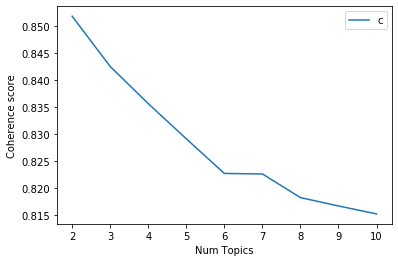

In [78]:
coherence_values = []
model_list = []
for num_topics in range(2, 11):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=list(repo_keywords), dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    print('cluster number:',num_topics, 'Coherence Score',coherencemodel.get_coherence())

# Show graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Build model with best topics

In [76]:
# Tune model with best value
model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=2, id2word=id2word)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=model, texts=list(repo_keywords), dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# Show Topics
pprint(model.show_topics(formatted=False))


Coherence Score:  0.8503421242642909
[(0,
  [('machine-learning', 0.05022075055187638),
   ('bioinformatics', 0.045805739514348784),
   ('visualization', 0.023730684326710817),
   ('deep-learning', 0.021799116997792495),
   ('statistics', 0.021799116997792495),
   ('simulation', 0.01793598233995585),
   ('genomics', 0.0173841059602649),
   ('python3', 0.016556291390728478),
   ('matlab', 0.016280353200883002),
   ('data-science', 0.016004415011037526)]),
 (1,
  [('python', 0.16446644664466448),
   ('julia', 0.03107810781078108),
   ('rstats', 0.028052805280528052),
   ('r-package', 0.0242024202420242),
   ('science', 0.019801980198019802),
   ('astronomy', 0.017051705170517052),
   ('physics', 0.016776677667766776),
   ('c-plus-plus', 0.016226622662266228),
   ('optimization', 0.015126512651265127),
   ('analysis', 0.01155115511551155)])]


### Viz the data

In [83]:
# Visualize the topics
for i, model in enumerate(model_list):
    lda_model_mallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model_mallet, corpus, id2word)
    pyLDAvis.save_html(vis, f'lda1-mallet-keyword-{i+2}.html')

/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/parambole/opt/anaconda3/envs/data-mining/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero en